<center><a href="https://sites.google.com/fat.uerj.br/livia/"> <img src="../images/capa2.png" alt="Header" style="width: 800px;"/> </a></center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/vnikoofard/DeepLearningTF/blob/main/notebooks/04a_asl_augmentation.ipynb)

# Aumento de dados (*data augmentation*)

Até agora, selecionamos uma arquitetura de modelo que melhora muito o desempenho do modelo, pois foi projetada para reconhecer recursos importantes nas imagens. A precisão da validação ainda está atrasada em relação à precisão do treinamento, o que é um sinal de overfitting: o modelo está ficando confuso com coisas que não viu antes ao testar o conjunto de dados de validação.

Para ensinar nosso modelo a ser mais robusto ao olhar para novos dados, vamos aumentar programaticamente o tamanho e a variação em nosso conjunto de dados. Isso é conhecido como [*aumento de dados*](https://link.springer.com/article/10.1186/s40537-019-0197-0), uma técnica útil para muitos aplicativos de aprendizado profundo.

O aumento no tamanho dá ao modelo mais imagens para aprender durante o treinamento. O aumento da variância ajuda o modelo a ignorar características sem importância e selecionar apenas as características que são realmente importantes na classificação, permitindo uma melhor generalização.

## Objetivos

* Aumente o conjunto de dados ASL
* Use os dados aumentados para treinar um modelo aprimorado
* Salve o modelo bem treinado em disco para uso na implantação (*deployment*)

## Preparando os dados

Como estamos em um novo notebook, iremos carregar e processar nossos dados novamente. Para fazer isso, execute a seguinte célula:

In [1]:
import tensorflow.keras as keras
import pandas as pd

# Load in our data from CSV files
train_url = "https://github.com/vnikoofard/DeepLearningTF/raw/main/data/asl_data/sign_mnist_train.csv"
valid_url = "https://github.com/vnikoofard/DeepLearningTF/raw/main/data/asl_data/sign_mnist_valid.csv"

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)
# Separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# Separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# Turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# Normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# Reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

2023-05-26 16:48:52.541489: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Criação de modelo

Também precisaremos criar nosso modelo novamente. Para fazer isso, execute a seguinte célula. Você notará que esta é a mesma arquitetura de modelo da última seção:

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

2023-05-26 16:50:13.752109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 16:50:13.849546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-26 16:50:13.849782: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

## Aumento de dados

Antes de compilar o modelo, é hora de configurar nosso aumento de dados.

Keras vem com uma classe de aumento de imagem chamada `ImageDataGenerator`. Recomendamos verificar a [documentação aqui](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator). Aceita uma série de opções para aumentar seus dados. Mais adiante no curso, faremos com que você selecione uma estratégia de aumento adequada. Por enquanto, dê uma olhada nas opções que selecionamos abaixo, e então execute a célula para criar uma instância da classe:

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # gira aleatoriamente as imagens no intervalo (graus, 0 a 180)
    zoom_range=0.1,  # Amplie a imagem aleatoriamente
    width_shift_range=0.1,  ## muda aleatoriamente as imagens horizontalmente (fração da largura total)
    height_shift_range=0.1,  # muda aleatoriamente as imagens verticalmente (fração da altura total)
    horizontal_flip=True,  # inverte aleatoriamente as imagens horizontalmente
    vertical_flip=False, # Não vire as imagens aleatoriamente na vertical
)  

Reserve um momento para pensar por que desejaríamos inverter as imagens horizontalmente, mas não verticalmente. Quando tiver uma ideia, revele o texto abaixo.

`# SOLUÇÃO` 

Nosso conjunto de dados são imagens de mãos assinando o alfabeto. Se quisermos usar esse modelo para classificar imagens de mãos posteriormente, é improvável que essas mãos fiquem de cabeça para baixo, mas podem ser canhotas. Esse tipo de raciocínio específico de domínio pode ajudar a tomar boas decisões para seus próprios aplicativos de aprendizado profundo.

## Tamanho do batch (*batch size*)
Outro benefício do `ImageDataGenerator` é que ele [batches](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent- batch-size/) nossos dados para que nosso modelo possa treinar em uma amostra aleatória.

Se o modelo for [verdadeiramente aleatório](http://sites.utexas.edu/sos/random/), o que significa que os dados estão devidamente embaralhados, de modo que seja justo como um baralho de cartas, então nossa amostra pode fazer um bom trabalho de representando todos os nossos dados, mesmo que seja uma pequena fração da população. Para cada etapa do treinamento, o modelo receberá um novo lote.

Na prática, um tamanho de lote de 32 e 64 funciona bem. Execute a célula abaixo para ver com que tipo de lotes estaremos treinando nosso modelo. Nosso randomizador é bastante aleatório? Todas as imagens são letras ASL reconhecíveis?

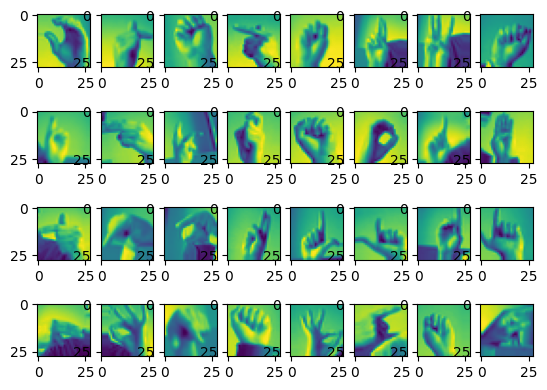

In [4]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Ajustando os Dados ao Gerador

Em seguida, o gerador deve ser ajustado ao conjunto de dados de treinamento.

In [5]:
datagen.fit(x_train)

## Compilando o Modelo

Com a instância do gerador de dados criada e ajustada aos dados de treinamento, o modelo agora pode ser compilado da mesma forma que nossos exemplos anteriores:

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Treino com Aumento de Dados

Ao usar um gerador de dados de imagem com Keras, um modelo treina um pouco diferente: em vez de apenas passar os conjuntos de dados `x_train` e `y_train` para o modelo, passamos o gerador, chamando o [flow] do gerador (https:// método keras.io/api/preprocessing/image/). Isso faz com que as imagens sejam aumentadas ao vivo e na memória antes de serem passadas para o modelo para treinamento.

Os geradores podem fornecer uma quantidade indefinida de dados e, quando os usamos para treinar nossos dados, precisamos definir explicitamente quanto tempo queremos que cada período seja executado, ou então o período continuará indefinidamente, com o gerador criando um número indefinido de imagens aumentadas para fornecer o modelo.

Definimos explicitamente quanto tempo queremos que cada época seja executada usando o argumento nomeado `steps_per_epoch`. Como `steps * batch_size = number_of_images_trained in an epoch`, uma prática comum, que usaremos aqui, é definir o número de etapas igual ao tamanho do conjunto de dados não aumentado dividido pelo batch_size (que tem um valor padrão de 32).

Execute a célula a seguir para ver os resultados. O treinamento levará mais tempo do que antes, o que faz sentido, já que agora estamos treinando com mais dados do que antes:

In [7]:
model.fit(img_iter,
          epochs=10,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/10


2023-05-26 16:50:35.383022: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-26 16:50:36.414113: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:1014] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-26 16:50:36.617932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-05-26 16:50:37.079800: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x79090c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-26 16:50:37.079848: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device

857/857 [==============================] - 16s 14ms/step - loss: 1.0949 - accuracy: 0.6526 - val_loss: 0.6036 - val_accuracy: 0.7794
Epoch 2/10
857/857 [==============================] - 11s 13ms/step - loss: 0.2998 - accuracy: 0.8989 - val_loss: 2.4504 - val_accuracy: 0.5607
Epoch 3/10
857/857 [==============================] - 11s 13ms/step - loss: 0.1825 - accuracy: 0.9411 - val_loss: 0.2097 - val_accuracy: 0.9214
Epoch 4/10
857/857 [==============================] - 11s 13ms/step - loss: 0.1429 - accuracy: 0.9530 - val_loss: 0.0631 - val_accuracy: 0.9795
Epoch 5/10
857/857 [==============================] - 11s 13ms/step - loss: 0.1175 - accuracy: 0.9625 - val_loss: 0.2426 - val_accuracy: 0.9155
Epoch 6/10
857/857 [==============================] - 11s 13ms/step - loss: 0.1084 - accuracy: 0.9669 - val_loss: 0.0981 - val_accuracy: 0.9688
Epoch 7/10
857/857 [==============================] - 11s 13ms/step - loss: 0.0955 - accuracy: 0.9700 - val_loss: 0.0346 - val_accuracy: 0.9872
Epo

## Discussão dos Resultados

Você notará que a precisão da validação é maior e mais consistente. Isso significa que nosso modelo não está mais superajustado como antes; ele generaliza melhor, fazendo melhores previsões sobre novos dados.

## Salvando o Modelo

Agora que temos um modelo bem treinado, queremos implantá-lo para realizar inferência em novas imagens.

É comum, uma vez que temos um modelo treinado com o qual estamos satisfeitos, salvá-lo em disco.

Salvar o modelo no Keras é bastante fácil usando o método save. Existem diferentes formatos nos quais podemos salvar, mas usaremos o padrão por enquanto. Se desejar, sinta-se à vontade para verificar [a documentação](https://www.tensorflow.org/guide/keras/save_and_serialize). No próximo notebook, carregaremos o modelo e o usaremos para ler novas imagens em língua de sinais:

In [8]:
model.save('asl_model.h5')

## Resumo

Nesta seção, você usou Keras para aumentar seu conjunto de dados, resultando em um modelo treinado com menos overfitting e excelentes resultados de imagem de validação.

### Resetar o ambiente
Antes de prosseguir, execute a célula a seguir para resetar o ambiente. Isso é necessário para passar para o próximo notebook.

In [ ]:
import os
os._exit(00)

: 

: 

## Next

Agora que você tem um modelo bem treinado salvo no disco, você irá, na próxima seção, implantá-lo para fazer previsões sobre imagens ainda não vistas.

Continue no próximo notebook: [*Previsões de modelo*](04b_asl_predictions.ipynb).